In [26]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 这一行注释掉就是使用gpu，不注释就是使用cpu

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pyDOE import lhs
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [27]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [28]:
class PINN:
    def __init__(self, ics_data, bcs_data, res_data, test_data, layers, activation, lr):
        self.ics_data = ics_data
        self.bcs_data = bcs_data
        self.res_data = res_data
        self.test_data = test_data
        self.lr = lr
        self.activation = activation
        self.loss_log = []
        self.loss_res_log = []
        self.loss_ics_log = []
        self.loss_bcs_log = []
        # initial neural network
        self.weights, self.biases = self.initilize_NN(layers)
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        # define placeholder
        # initial condition
        self.u_i_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_i_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_i_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        # boundary condition
        self.t_b_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_b_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        # collocation points
        self.t_r_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_r_tf  = tf.placeholder(tf.float32, shape=[None, 1])
        # define u, f, residual loss
        self.u_res   = self.net_u(self.x_r_tf, self.t_r_tf)
        self.f       = self.net_f(self.u_res, self.x_r_tf, self.t_r_tf)
        self.loss_res= tf.reduce_mean(tf.square(self.f))
        # Dirichlet boundary
        self.u_bcs   = self.net_u(self.x_b_tf, self.t_b_tf)
        self.loss_bcs= tf.reduce_mean(tf.square(self.u_bcs))
        self.u_ics   = self.net_u(self.x_i_tf, self.t_i_tf)
        self.loss_ics= tf.reduce_mean(tf.square(self.u_ics - self.u_i_tf))
        # total loss function
        self.loss    = self.loss_res + self.loss_bcs + self.loss_ics
        # define Adam optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss)
        init = tf.global_variables_initializer()
        self.sess.run(init)
    '''
    function : initilize_NN
    input    : layers  (list)
    output   : weights ([tf.Variable]), biases ([tf.Variable])
    '''
    def initilize_NN(self, layers):
        weights = []
        biases  = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases
    '''
    function : xavier init
    input    : size [layer_in, layer_out]
    output   : W_in_out (tf.Variable)
    '''
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    '''
    function : neural_net
    input    : X -- input of the NN, weights, biases, activation
    output   : Y -- output of the NN
    '''
    def neural_net(self, X, weights, biases, activation):
        num_layers = len(weights) + 1
        H = X
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = activation(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    '''
    define u
    '''
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x, t], 1), self.weights, self.biases, self.activation)
        return u
    '''
    define f (residual loss)
    '''
    def net_f(self, u, x, t):
        u_t  = tf.gradients(u, t)[0]
        u_x  = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        return u_t + u*u_x - 0.01 / np.pi * u_xx

    def train(self, max_iter=40000, show=False):
        for iter in range(max_iter):
            u_i, y_i = self.ics_data.get_batch()
            y_b      = self.bcs_data.get_batch()[1]
            y_r      = self.res_data.get_batch()[1]
            tf_dict = {
                self.x_r_tf : y_r[:, 0][:, None],
                self.t_r_tf : y_r[:, 1][:, None],
                self.x_b_tf : y_b[:, 0][:, None],
                self.t_b_tf : y_b[:, 1][:, None],
                self.x_i_tf : y_i[:, 0][:, None],
                self.t_i_tf : y_i[:, 1][:, None],
                self.u_i_tf : u_i
            }
            _, loss_value, si, sb, sr= self.sess.run([self.optimizer,
                self.loss, self.loss_ics, self.loss_bcs, self.loss_res], tf_dict)
            self.loss_res_log.append(sr)
            self.loss_bcs_log.append(sb)
            self.loss_ics_log.append(si)
            self.loss_log.append(loss_value)
            if iter % 1000 == 0:
                print("第%d次 %f,ic %f,bc %f,res %f"%(iter, loss_value, si, sb, sr))
                self.compute_error()
                if show == True:
                    self.show_u()
                    self.scatter_xt()
            if iter % 100 == 0:
                self.RAR_method(10)
        self.show_u()
        print("第%d次的损失为%f"%(max_iter, loss_value))

    def predict(self, X_star, T_star):
        u_star = self.sess.run(self.u_res, {self.x_r_tf: X_star, self.t_r_tf: T_star})
        return u_star

    def show_u(self):
        x_test = np.linspace(-1, 1, 256)[:, None]
        t_test = np.linspace(0, 1, 100)[:, None]
        X, T = np.meshgrid(x_test, t_test)
        x_test = X.flatten()[:, None]
        t_test = T.flatten()[:, None]
        u_pred = self.predict(x_test, t_test)
        u_pred = np.reshape(u_pred, (100, 256))
        fig = plt.figure(figsize=(6,5))
        plt.pcolor(X, T, u_pred, cmap='jet')
        plt.xlabel('$x$')
        plt.ylabel('$t$')
        plt.title('Predict $u(x,t)$')
        plt.colorbar()
        plt.tight_layout()
        plt.savefig('Pred u.pdf')
        plt.show()

    def scatter_xt(self):
        try:
            x   = self.res_data.y_[:, 0][:, None]
            t   = self.res_data.y_[:, 1][:, None]
            fig = plt.figure(figsize=(6,5))
            plt.scatter(x, t)
            plt.xlabel('$x$')
            plt.ylabel('$t$')
            plt.xlim([-1, 1])
            plt.ylim([0, 1])
            plt.tight_layout()
            plt.show()
        except:
            pass

    def RAR_method(self, m):
        # pick the largest loss f(x,t)
        lb = np.array([-1.,  0.])
        ub = np.array([1.  , 0.99])
        y_f= lb + (ub-lb)*lhs(2, self.res_data.batch_size)
        x  = y_f[:, 0][:, None]
        t  = y_f[:, 1][:, None]
        u  = self.sess.run(self.u_res, {self.x_r_tf: x, self.t_r_tf: t})
        f  = np.square(self.sess.run(self.f, {self.u_res:u, self.x_r_tf: x, self.t_r_tf: t}))
        ind= np.argmax(f, 0)[0]
        x_ = x[ind][0]
        t_ = t[ind][0]
        # generate new data.
        eps= 0.0001
        lb_ = np.array([x_-eps, t_-eps])
        ub_ = np.array([x_+eps, t_+eps])
        y_new = lb_ + 1 / 2 * (ub_ - lb_) * lhs(2, m)
        self.res_data.add_points(y_new)

    def compute_error(self):
        u_pred = self.predict(self.test_data.y[:, 0][:, None], self.test_data.y[:, 1][:, None])
        u_star = self.test_data.u
        error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
        print('Error u: %e' % (error_u))

In [29]:
# generate batch size data
class DataGenerator():
    def __init__(self, u, y, batch_size):
        self.u = u
        self.y = y
        self.y_ = None
        self.batch_size = batch_size

    def get_batch(self):
        N = self.u.shape[0]
        index = np.random.randint(0, N, self.batch_size)
        u_ = self.u[index, :]
        y_ = self.y[index, :]
        return u_, y_

    def add_points(self, y):
        self.y = np.vstack((self.y, y))
        self.batch_size = (self.y).shape[0]
        if self.y_ is None:
            self.y_ = y
        else :
            self.y_ = np.vstack((self.y_, y))

In [30]:
data = scipy.io.loadmat(r"D:\Documents\grade4term1\PDE\数学基础\NN\TF_learn\PINN\appendix\Data\burgers_shock.mat")
t = data['t']
x = data['x']
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]
test_data = DataGenerator(u_star, X_star, 0)

In [31]:
'''
Generate ics data & bcs data
'''
batch_size_ics = 256
batch_size_bcs = 100
# ics
x1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
u1 = Exact[0:1,:].T
ics_data = DataGenerator(u1, x1, batch_size_ics)
# bcs x=-1
x2 = np.hstack((X[:,0:1], T[:,0:1]))
u2 = Exact[:,0:1]
# bcs x=1
x3 = np.hstack((X[:,-1:], T[:,-1:]))
u3 = Exact[:,-1:]
bcs_data = DataGenerator(np.vstack([u2, u3]), np.vstack([x2, x3]), batch_size_bcs)

In [32]:
layers = [2, 32, 32, 32, 32, 32, 1]
activation = tf.tanh
lr = 1e-3
iterations = 20000

'''
Generate res data
'''
N_f = 1500
# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)
def train_model(N_f, show_u):
    X_f_train = lb + (ub-lb)*lhs(2, N_f) # pyODE.lhs 拉丁超立方体抽样
    batch_size_res = N_f
    res_data  = DataGenerator(np.zeros((N_f, 1)), X_f_train, batch_size_res)
    start_time = time.time()
    PINN_tanh = PINN(ics_data, bcs_data, res_data, test_data, layers, activation, lr)
    print("Start training! N_f:%d"%(N_f))
    PINN_tanh.train(iterations, show_u)
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))
    return PINN_tanh

In [33]:
def compute_error(model):
    u_pred = model.predict(X_star[:, 0][:, None], X_star[:, 1][:, None])
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    print('Error u: %e' % (error_u))
    return error_u

Start training! N_f:1500
第0次 0.560989,ic 0.558659,bc 0.001324,res 0.001006
Error u: 9.864039e-01
第1000次 0.110348,ic 0.059880,bc 0.003484,res 0.046983
Error u: 4.832680e-01
第2000次 0.085912,ic 0.051248,bc 0.001246,res 0.033418
Error u: 4.058302e-01
第3000次 0.068103,ic 0.036280,bc 0.000371,res 0.031452
Error u: 3.309658e-01
第4000次 0.018469,ic 0.007921,bc 0.001149,res 0.009399
Error u: 4.113575e-01
第5000次 0.014302,ic 0.008233,bc 0.000249,res 0.005821
Error u: 3.963915e-01
第6000次 0.007200,ic 0.004519,bc 0.000049,res 0.002633
Error u: 4.172283e-01
第7000次 0.005820,ic 0.003740,bc 0.000094,res 0.001985
Error u: 4.286730e-01
第8000次 0.002652,ic 0.001384,bc 0.000006,res 0.001262
Error u: 2.037222e-01
第9000次 0.002274,ic 0.001257,bc 0.000044,res 0.000973
Error u: 1.970957e-01
第10000次 0.002257,ic 0.001210,bc 0.000009,res 0.001038
Error u: 3.004899e-01
第11000次 0.001834,ic 0.001162,bc 0.000004,res 0.000668
Error u: 2.987283e-01
第12000次 0.001397,ic 0.000846,bc 0.000003,res 0.000548
Error u: 2.784289e-01


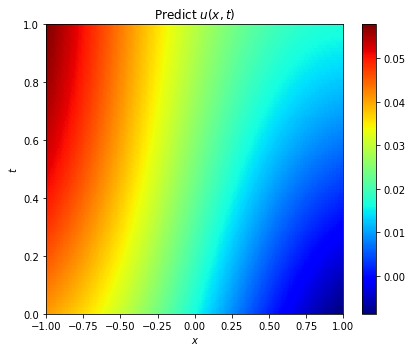

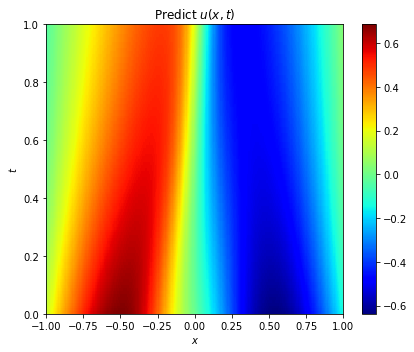

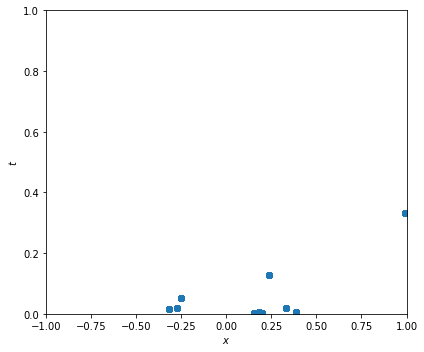

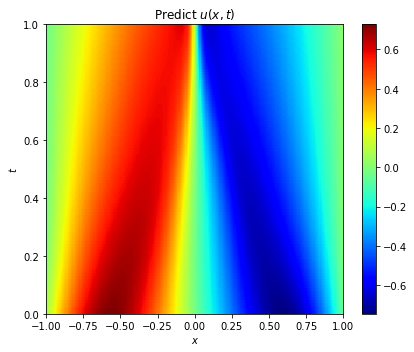

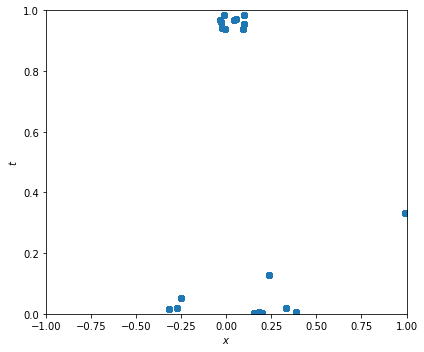

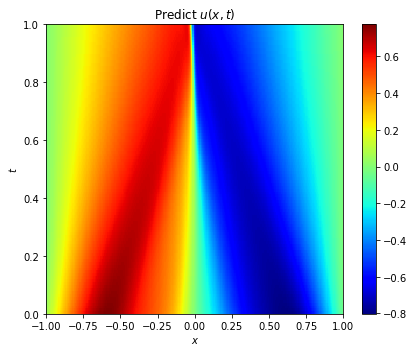

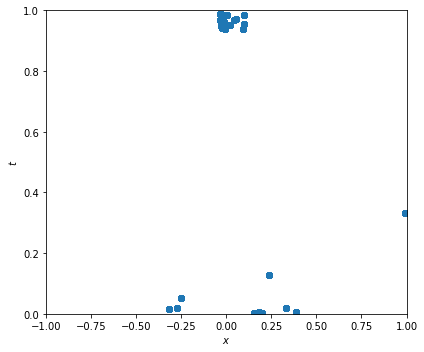

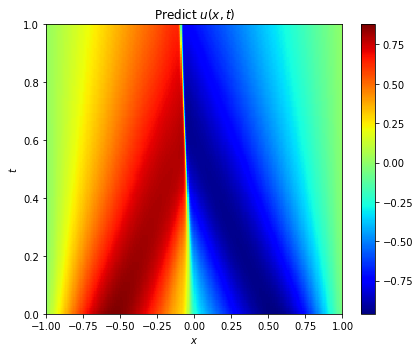

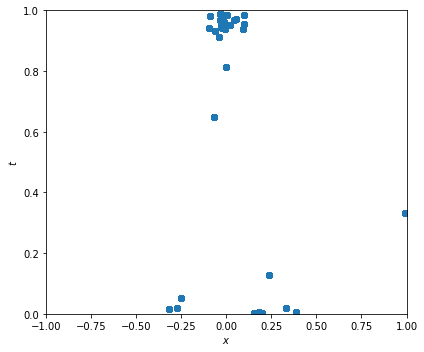

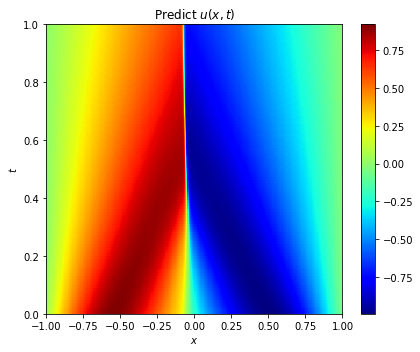

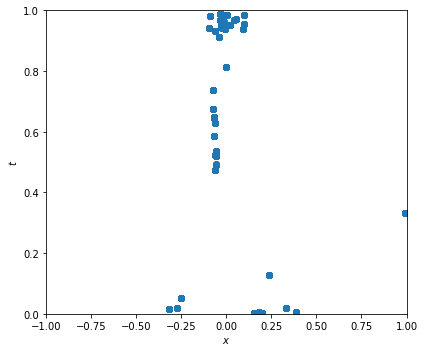

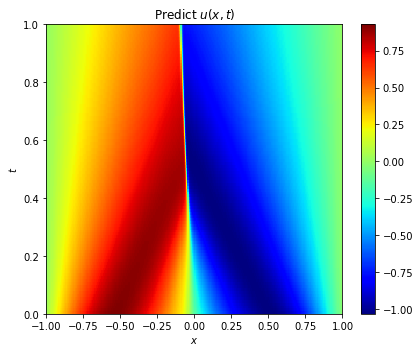

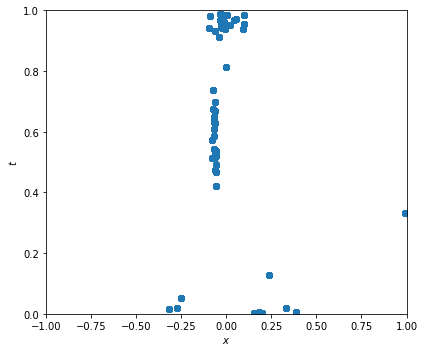

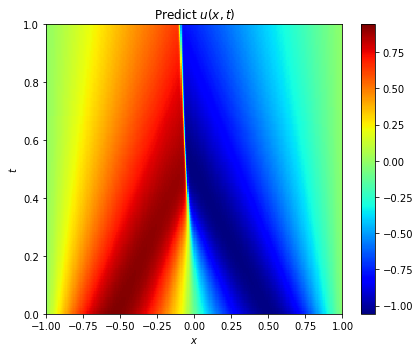

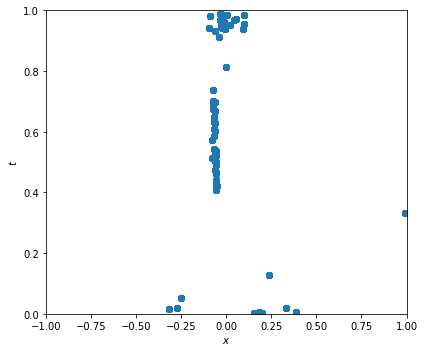

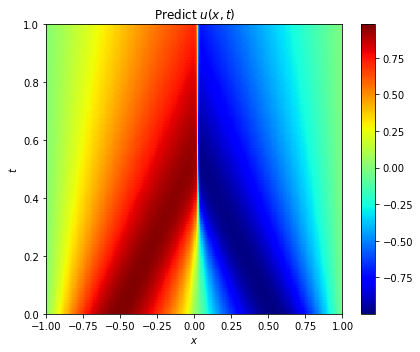

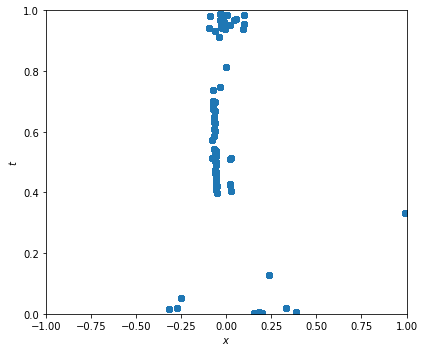

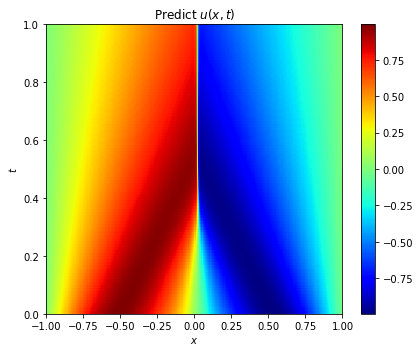

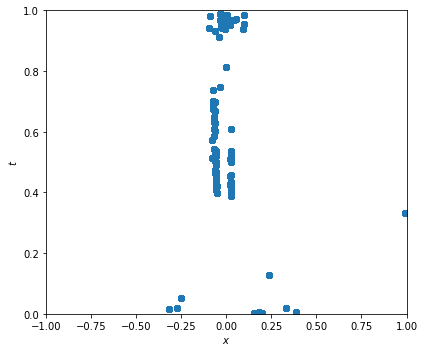

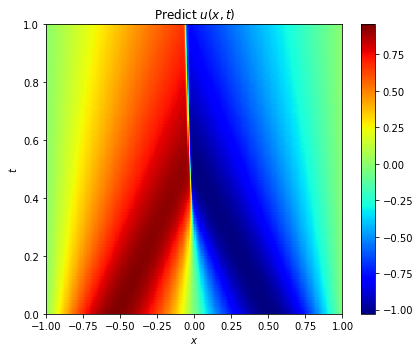

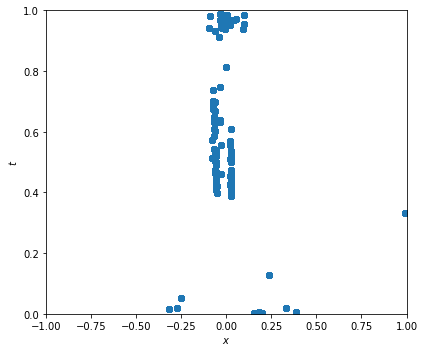

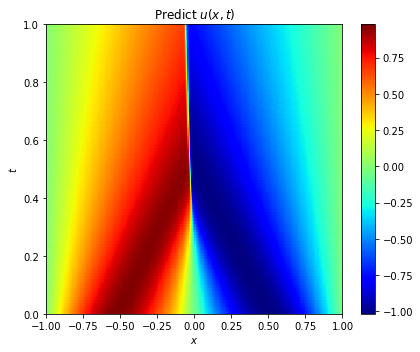

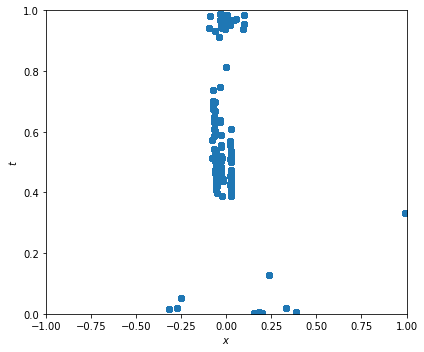

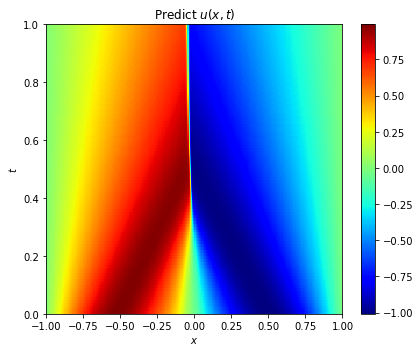

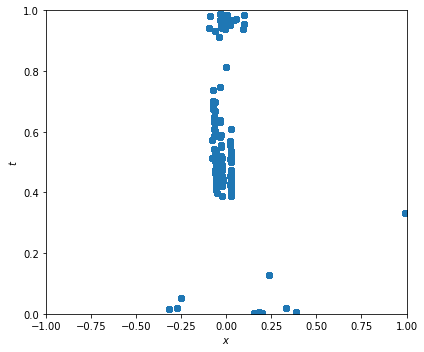

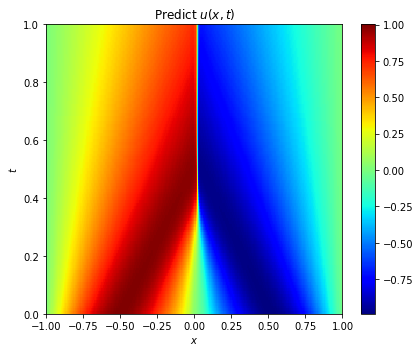

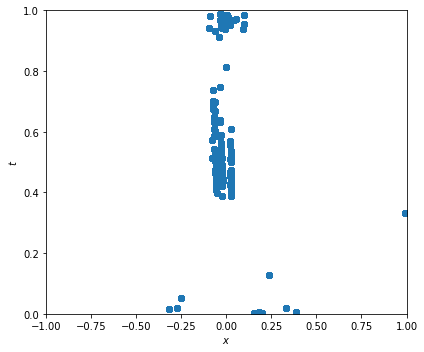

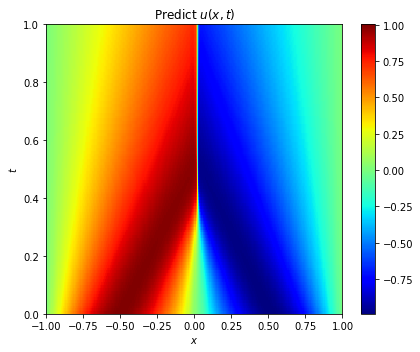

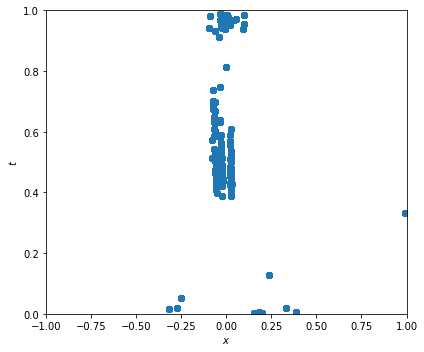

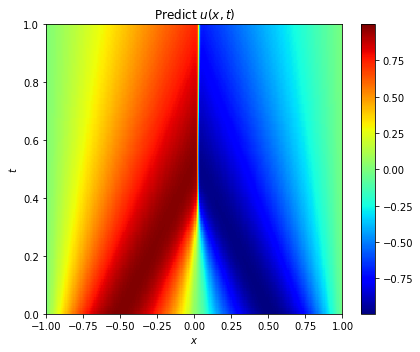

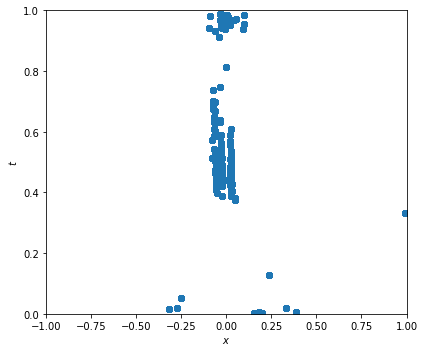

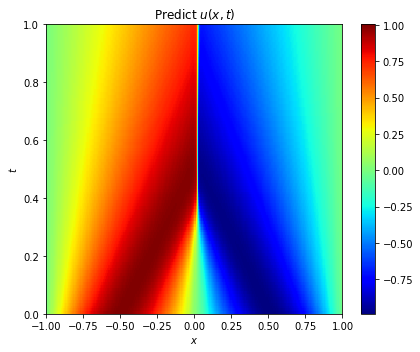

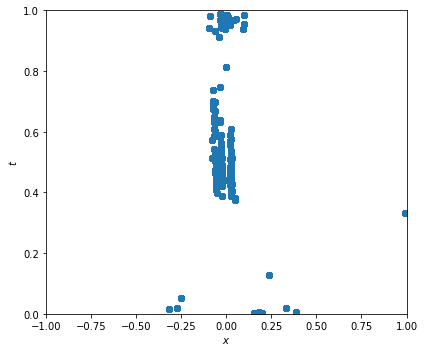

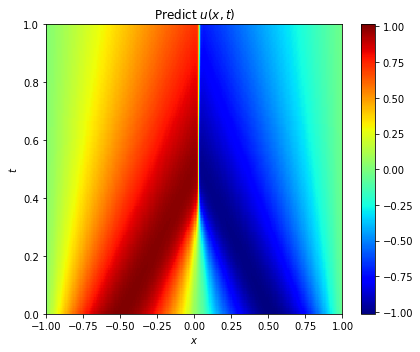

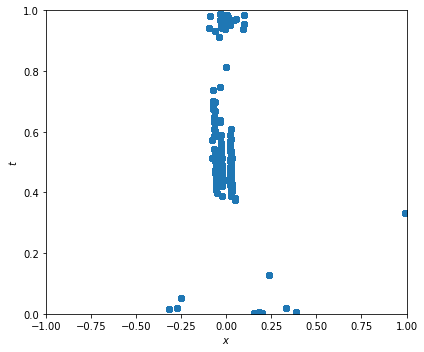

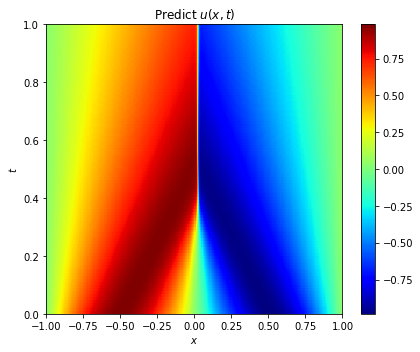

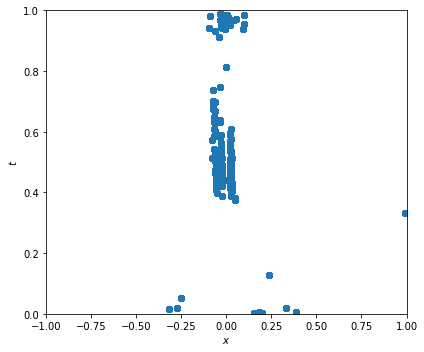

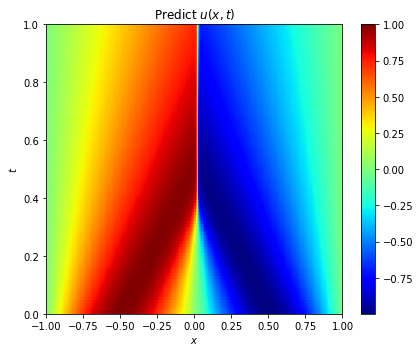

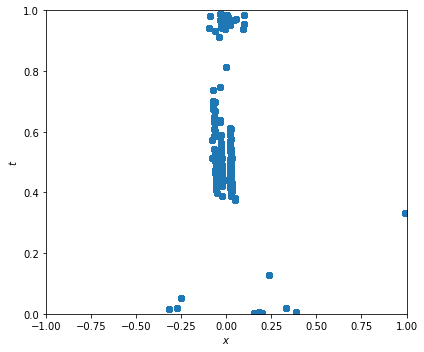

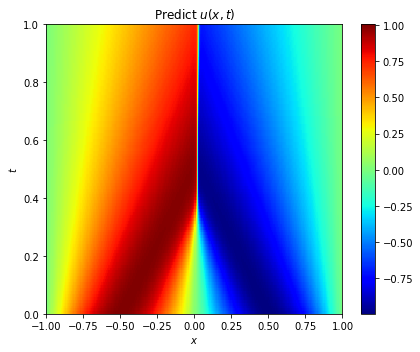

In [34]:
show_u = True
model = train_model(N_f, show_u)
error = compute_error(model)
print("N_f:%d, error:%f"%(N_f, error))